In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from matplotlib import pyplot as plt
import gc
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb

from sklearn.model_selection import KFold

In [6]:
target = 'VA.NOX($mg/m^{3}$)'
time_col = "时间"
DATE = "DATE"

In [9]:
df = pd.read_csv("data\qiyeshuju-4S间隔.csv", parse_dates = ["时间"], encoding='gbk')
df[DATE] = df[time_col].dt.date
df[DATE] = pd.to_datetime(df[DATE])

In [10]:
min(df[DATE]), max(df[DATE])


(Timestamp('2023-12-11 00:00:00'), Timestamp('2024-01-12 00:00:00'))

<Axes: >

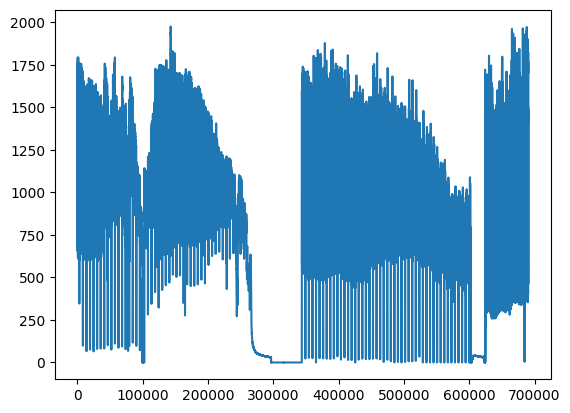

In [11]:
df[target].plot()

In [12]:
df[df[DATE] == pd.to_datetime("2023-12-11")]

,时间,右侧换火信号,CEMS出口烟尘($mg/m^{3}$),CEMS出口一氧化氮($mg/m^{3}$),VA.SO2($mg/m^{3}$),VA.NOX($mg/m^{3}$),CEMS出口含氧(%),VA.O2(%),NOX转换值($mg/m^{3}$),氨水泵B频率反馈(Hz),...,CCF7差压,烟气量($Nm^{3}/h$),CCF出口压力,CEMS出口流量(m/s),22出口CEMS温度,22CEMS出口烟尘($mg/m^{3}$),出口CEMS湿度(%),22烟气量($Nm^{3}/h$),右侧换火信号-数值,DATE
0,2023-12-11 18:48:28,ON,1.489622,NaN,285.446289,1589.728149,11.520146,11.95911,25.152626,-0.4884,...,1186.813232,139874.937500,-2595.848633,3.008547,170.915756,1.489622,8.224665,146038.921875,2,2023-12-11
1,2023-12-11 18:48:32,ON,1.501832,NaN,283.894104,1599.266113,11.514042,11.96279,23.443224,-0.4884,...,1179.487183,146038.921875,-2600.732666,3.008547,170.915756,1.501832,8.224665,146038.921875,2,2023-12-11
2,2023-12-11 18:48:36,ON,1.514042,NaN,282.561707,1608.487427,11.514042,11.97013,23.443224,-0.4884,...,1179.487183,143194.000000,-2605.616699,2.862027,170.915756,1.514042,8.224665,138926.640625,2,2023-12-11
3,2023-12-11 18:48:40,ON,1.465201,NaN,281.370392,1616.558228,11.507936,11.97983,21.489622,-0.4884,...,1177.045166,143194.000000,-2605.616699,2.862027,170.915756,1.465201,8.224665,138926.640625,2,2023-12-11
4,2023-12-11 18:48:44,ON,1.489622,NaN,278.687805,1633.776855,11.495727,12.00196,17.704517,-0.4884,...,1169.719116,138926.640625,-2600.732666,2.979243,170.915756,1.489622,8.224665,144616.468750,2,2023-12-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4668,2023-12-11 23:59:40,OFF,1.306471,NaN,285.356415,1451.292847,11.837606,12.00074,-0.366300,-0.4884,...,1184.371216,137504.187500,-2459.096436,2.949939,169.450546,1.294261,8.009768,143194.000000,4,2023-12-11
4669,2023-12-11 23:59:44,OFF,1.318681,NaN,288.625214,1438.975464,11.837606,11.99474,-0.366300,-0.4884,...,1177.045166,144616.468750,-2459.096436,2.920635,169.450546,1.282051,8.009768,141771.546875,4,2023-12-11
4670,2023-12-11 23:59:48,OFF,1.306471,NaN,291.987000,1428.270142,11.849817,11.98715,-0.244200,-0.4884,...,1174.603149,140349.093750,-2459.096436,2.891331,169.450546,1.294261,8.019536,140349.093750,4,2023-12-11
4671,2023-12-11 23:59:52,OFF,1.306471,NaN,295.088287,1420.688110,11.862027,11.98139,-0.244200,-0.4884,...,1184.371216,137504.187500,-2459.096436,2.949939,169.450546,1.318681,8.029305,143194.000000,4,2023-12-11


In [13]:
plot_date =lambda date: plt.plot(df[df[DATE] == pd.to_datetime(date)][time_col], df[df[DATE] == pd.to_datetime(date)][target], ) 

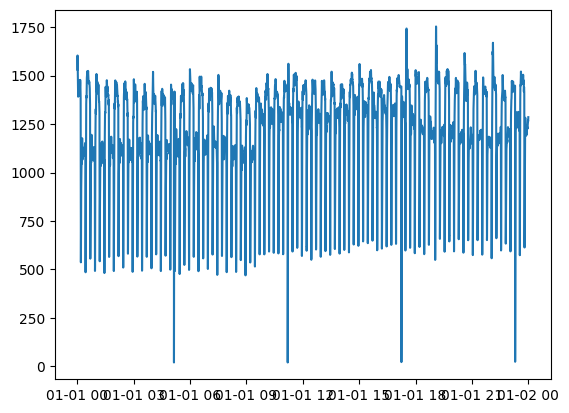

In [14]:
plot_date("2024-01-01")

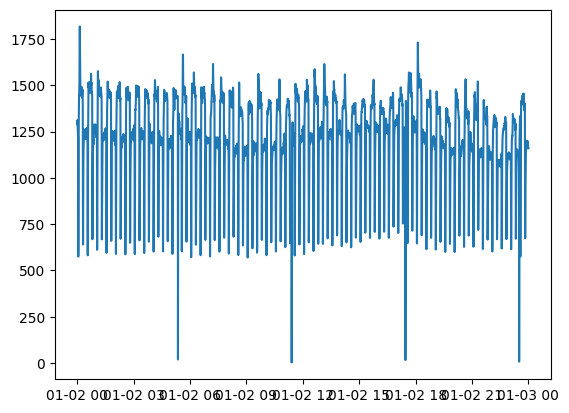

In [15]:
plot_date("2024-01-02")

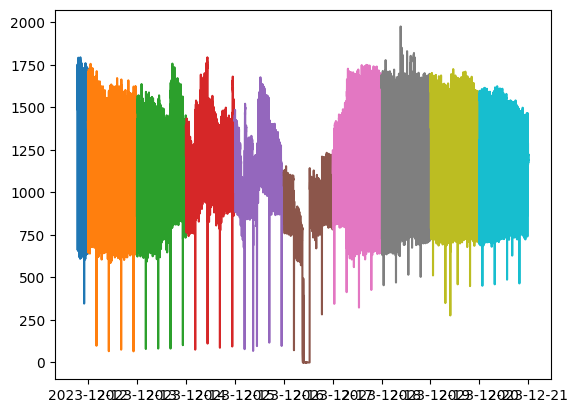

In [16]:
i = 0
for date, chunk in df.groupby([DATE]):
    plt.plot(chunk[time_col], chunk[target])
    i += 1
    if i == 10:
        break

# 特征工程

In [17]:
#!/usr/bin/env python
# coding=utf-8
'''
Author: Li Yuhao
Date: 2021-11-30 20:09:05
LastEditTime: 2022-05-25 18:37:08
LastEditors: your name
Description: 
'''
import os
import pathlib
import time
from datetime import datetime, timedelta
from functools import wraps
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


MINUTE = 60
HOUR = 60 * MINUTE
DAY = 24 * HOUR


class FeatureEngineer():
    def __init__(
            self, 
            data: pd.DataFrame,
            time_fea: str, 
            target_fea: str,
            groupby_feature_list: List[str] = [],
            lag_list: List[int] = [], 
            window_list: List[timedelta] = [], 
            ewm_alpha_list: List[float] = [],
            ewm_lag_list: List[int] = [],
            drop_col_list: List[str] = [],
            # forecast_time: str = "", 
            seed: int = None) -> None:
        self.data = data
        self.time_fea = time_fea
        self.target_fea = target_fea
        self.groupby_feature_list = groupby_feature_list
        self.lag_list = lag_list
        self.window_list = window_list
        self.ewm_alpha_list = ewm_alpha_list
        self.ewm_lag_list = ewm_lag_list
        self.drop_col_list = drop_col_list
        self.seed = seed
        # 时间特征名称
        self.time_fea_list = []
        # 时间类别特征名称
        self.time_category_fea_list = []
        if seed:
            np.random.seed(seed)
        
        # # 需要预测的开始日期
        # self.forecast_time = pd.to_datetime(forecast_time)

        # 转换时间特征
        self.data[time_fea] = pd.to_datetime(self.data[time_fea])

        # # 需要预测的天数
        # self.forecast_horizon = (max(self.data[time_fea]) - self.forecast_time)
        # self.forecast_horizon_days = self.forecast_horizon.days
        # # 修正需要预测的日期的数据，避免数据泄露
        # self.future_real_data = self.data[data[time_fea] >= self.forecast_time][target_fea]
        # self.data.loc[data[time_fea] >= self.forecast_time, target_fea] = np.nan  

        # 数据是否做过log变换
        self.is_log_transformed = False

        return

    def add_time_series_features(self) -> pd.DataFrame:
        '''
        description: 
        param [DataFrame] df
        return [*]
        '''
        df = self.data
        # 修改时间列名
        df.rename({self.time_fea: "date"}, axis= 1, inplace=True)

        # 设置时间列为索引
        self.pre_index_fea = "index"
        while self.pre_index_fea in df.columns:
            self.pre_index_fea += "_"
        df[self.pre_index_fea] = df.index
        df.set_index("date", inplace=True)
        df.index = pd.DatetimeIndex(df.index)
        
        # 对数据进行排序
        df.sort_values("date", inplace = True, ascending = True)

        # # 1. 对数据做log变换
        # # 归一化 大于等于0
        # self.min_y = min(df[self.target_fea])
        # self.standardize_target(
        #     df = df, 
        #     target_fea=self.target_fea, 
        #     min_y=self.min_y)
        
        # 2. 创建时间特征
        self.create_date_features(df = df)

        # 3. 增加“前n天y值”特征，并增加随机噪音
        self.lag_features(
            df = df, 
            lag_list = self.lag_list, 
            target_fea = self.target_fea, 
            groupby_feature_list = self.groupby_feature_list) # Let's create
        
        # 4. 增加窗口特征
        self.roll_mean_features(
            df = df, 
            window_list=self.window_list, 
            target_fea = self.target_fea,
            groupby_feature_list = self.groupby_feature_list)

        # 增加权重特征数据增加权重
        self.ewm_features(
            df = df, 
            ewm_alpha_list = self.ewm_alpha_list,
            ewm_lag_list = self.ewm_lag_list
        )

        # 5. 删除列
        # 删除唯一值的特征
        # one_value_col_list = []
        # for col in df.columns:
        #     if len(df[col].value_counts()) == 1:
        #         one_value_col_list.append(col)
        # df.drop(labels=[item for item in df.columns if item in self.drop_col_list],axis = 1 ,inplace=True)

        # 修改时间列名
        df[self.time_fea] = df.index
        df.set_index(self.pre_index_fea, inplace=True)
        
        return

    # 对数据做log变换
    def standardize_target(self, df: pd.DataFrame, target_fea: str, min_y: float) -> pd.DataFrame:
        if self.is_log_transformed:
            return
        # We are standardizing by using logarithmic transformation
        df[target_fea] = df[target_fea] - min_y
        df[target_fea] = np.log1p(df[target_fea].values)
        self.is_log_transformed = True
        return 

    def re_standardize_target(self, y, min_y):
        if self.is_log_transformed == False:
            return
        y = np.expm1(y)
        y = y + min_y
        self.is_log_transformed == False
        return y


    # 创建时间特征
    def create_date_features(self, df: pd.DataFrame):
        '''
        description: 创建时间特征

        param [pd] df
        
        return [*]
        '''
        # 检查几个时间特征列是否存在
        time_fea_list = [
            "month", "day_of_month", "day_of_year", "week_of_year", "day_of_week", 
            "year", "is_wknd", "is_month_start", "is_month_end"]
        for tmp_fea in time_fea_list:
            if tmp_fea not in df.columns:
                df[tmp_fea] = np.nan

        df["month"] = df.index.month # Which month of the corresponding year
        df["day_of_month"] = df.index.day
        df["day_of_year"] = df.index.dayofyear
        df["week_of_year"] = df.index.isocalendar().week.astype(np.int8)
        df["day_of_week"] = df.index.dayofweek
        df["year"] = df.index.year
        
        # 手动添加额外字段
        df["is_wknd"] = df.index.weekday // 5# df.index.weekday => Starts from '0' means '0' = 'Monday'. So, '// 4' will give '1' when day number equals
        # to '5'(which corresponds 'Saturday') and '6'(which corresponds 'Sunday') and '0' for rest of them. Consequently this column will represent whether 
        # the day is weekend or not

        # Is it starting of the corresponding month
        df["is_month_start"] = df.index.is_month_start.astype(int)
        
        # Is it ending of the corresponding month
        df["is_month_end"] = df.index.is_month_end.astype(int)
        
        # 添加时间特征名称
        self.time_fea_list.extend(time_fea_list)
        self.time_category_fea_list.extend(time_fea_list)
        return 

    # add random noise 增加正态分布随机数
    def random_noise(self, df: pd.DataFrame, target_fea: str):
        return 0.01 * np.random.normal(scale=np.std(df[target_fea]), size=(len(df),)) # Gaussian random noise

    # add lag features 增加时间间隔特征
    def lag_features(
            self, 
            df: pd.DataFrame, 
            lag_list: List[int], 
            target_fea: str, 
            groupby_feature_list: List[str] = []
        ) -> pd.DataFrame:
        '''
        description: 

        param [DataFrame] df 待处理数据表

        param [List] lag_list 前n个特征

        param [str] target_fea 目标特征名称

        param [List] groupby_feature_list 聚合特征名称列表，为空则不进行聚合处理
        
        return [*]
        '''        
        if not isinstance(groupby_feature_list, list):
            groupby_feature_list = [groupby_feature_list]
        for lag in lag_list:
            feature_name = f"{target_fea}_lag_{lag}"
            self.time_fea_list.append(feature_name)
            # 取数据
            if groupby_feature_list == []:
                df[feature_name] = df[target_fea].transform(lambda x: x.shift(lag))
            else:
                df[feature_name] = df.groupby(groupby_feature_list)[target_fea].transform(lambda x: x.shift(lag))
            # Again adding random noise
            # df[feature_name] = df[feature_name] + self.random_noise(df, target_fea)  
        
        return 


    # Let's create "rolling mean features". 增加时间窗平均
    def roll_mean_features(
            self,
            df: pd.DataFrame,
            window_list: List[timedelta],
            target_fea: str,
            groupby_feature_list: List[str] = [], 
        ) -> pd.DataFrame:
        '''
        description: 

        param [DataFrame] df 待处理数据表

        param [List] window_list 指定时间窗大小

        param [str] target_fea 目标特征名称

        param [List] groupby_feature_list 聚合特征名称列表，为空则不进行聚合处理

        return [*]
        '''
        if not isinstance(groupby_feature_list, list):
            groupby_feature_list = [groupby_feature_list]
        # 增加均值特征
        for window in window_list:
            if isinstance(window, timedelta):
                window = float(window.total_seconds() / DAY)
            # elif isinstance(window, int):
            #     # 检查window的size，如果大于列长度，会报诡异的malloc(): invalid size (unsorted)错误
            #     if window >= len(self.data[self.target_fea]):
            #         continue
                
            feature_name = f"{target_fea}_roll_mean_{window}_min"
            self.time_fea_list.append(feature_name)
            # 添加特征
            if groupby_feature_list == []:
                df[feature_name] = df[target_fea].shift(1).rolling("{0:.2f}D".format(window)).mean()
            else:
                df[feature_name] = df.groupby(groupby_feature_list)[target_fea]. \
                                                transform(lambda x: x.shift(1).rolling("{0:.2f}D".format(window)).mean())
            # 添加高斯分布随机数
            df[feature_name] = df[feature_name] + self.random_noise(df, target_fea)  # Again adding random noise
        # 增加方差特征
        for window in window_list:
            if isinstance(window, timedelta):
                window = float(window.total_seconds() / DAY)
            # elif isinstance(window, int):
            #     # 检查window的size，如果大于列长度，会报诡异的malloc(): invalid size (unsorted)错误
            #     if window >= len(self.data[self.target_fea]):
            #         continue
            feature_name = f"{target_fea}_roll_std_{window}_min"
            self.time_fea_list.append(feature_name)

            if groupby_feature_list == []:
                # 增加窗口方差特征
                # .std() 计算公式: sqrt(\sum( x_i - ave_x ) / (num_x - 1) )
                df[feature_name] = df[target_fea].shift(1).rolling("{0:.2f}D".format(window)).std()
            else:
                df[feature_name] = df.groupby(groupby_feature_list)[target_fea]. \
                    transform(lambda x: x.shift(1).rolling("{0:.2f}D".format(window)).std()) 
            # 添加高斯分布随机数
            df[feature_name] = df[feature_name] + self.random_noise(df, target_fea)  # Again adding random noise
        return 
    
    # 增加权重特征
    def ewm_features(
            self, 
            df: pd.DataFrame, 
            ewm_alpha_list: List[float], 
            ewm_lag_list: List[int], 
            target_fea: str = None,
        ):
        '''
        description: 

        param [DataFrame] df 待处理数据表

        param [List] ewm_alpha_list 权重大小列表

        param [List] ewm_lag_list 给前n个数据加权重
        
        return [*]
        '''
        if not target_fea:
            target_fea = self.target_fea
        # 开始进行处理
        for alpha in ewm_alpha_list:
            for lag in ewm_lag_list:
                feature_name = f"{self.target_fea}_ewm_alpha_{str(alpha).replace('.', '')}_lag_{lag}"
                self.time_fea_list.append(feature_name)
                # 防止不存在列错误
                if feature_name not in df.columns:
                    df[feature_name] = np.nan
                df[feature_name] = df[target_fea].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
        return df

In [20]:

time_fea = time_col
target_fea = target

lag_list = [24 * i for i in range(1, 8)] + list(range(1, 24))
window_list = [] # [24 * i for i in range(1, 2)] + [24 * i for i in [30, 90, 180,270]] + list(range(1, 24))
ewm_alpha_list = [] # [0.9]
ewm_lag_list = [] #  [24 * i for i in range(1, 2)] + [24 * i for i in [30, 90, 180,270]] + list(range(1, 24))


fe = FeatureEngineer(
    data = df[[time_fea, target_fea]].copy(),
    time_fea = time_fea,
    target_fea = target_fea,
    lag_list = lag_list, 
    window_list = window_list,
    ewm_alpha_list = ewm_alpha_list,
    ewm_lag_list = ewm_lag_list,
)

fe.add_time_series_features()
fe.data

,VA.NOX($mg/m^{3}$),month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,...,VA.NOX($mg/m^{3}$)_lag_15,VA.NOX($mg/m^{3}$)_lag_16,VA.NOX($mg/m^{3}$)_lag_17,VA.NOX($mg/m^{3}$)_lag_18,VA.NOX($mg/m^{3}$)_lag_19,VA.NOX($mg/m^{3}$)_lag_20,VA.NOX($mg/m^{3}$)_lag_21,VA.NOX($mg/m^{3}$)_lag_22,VA.NOX($mg/m^{3}$)_lag_23,时间
index,,,,,,,,,,,,,,,,,,,,,
0,1589.728149,12,11,345,50,0,2023,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-11 18:48:28
1,1599.266113,12,11,345,50,0,2023,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-11 18:48:32
2,1608.487427,12,11,345,50,0,2023,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-11 18:48:36
3,1616.558228,12,11,345,50,0,2023,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-11 18:48:40
4,1633.776855,12,11,345,50,0,2023,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-12-11 18:48:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690331,1420.699707,1,12,12,2,4,2024,0,0,0,...,1405.809326,1405.422607,1414.722046,1424.188843,1433.351318,1441.402466,1453.546265,1455.654663,1453.878418,2024-01-12 17:09:52
690332,1429.226685,1,12,12,2,4,2024,0,0,0,...,1409.294067,1405.809326,1405.422607,1414.722046,1424.188843,1433.351318,1441.402466,1453.546265,1455.654663,2024-01-12 17:09:56
690333,1436.949707,1,12,12,2,4,2024,0,0,0,...,1413.280151,1409.294067,1405.809326,1405.422607,1414.722046,1424.188843,1433.351318,1441.402466,1453.546265,2024-01-12 17:10:00


# 训练模型

## 划分数据集

In [21]:
split_date = "20240112000000"
valid_date = "20240109000000"

data = fe.data.copy()

params_ = {
    'eta': 0.01,
    'max_depth': 11,
    'subsample': 0.6,
    'n_estimators': 3000,
    'reg_alpha': 40,
    'reg_lambda': 18,
    'min_child_weight': 16,
    'metric': 'rmse',
    # 'tree_method': 'gpu_hist',
    'verbose_eval': 100
}

Early_Stopping_Rounds = 150
N_round = 8000
Verbose = 100
log1p = None

train_data = data[data[time_col] < split_date]
test_data = data[data[time_col] >= split_date]

train_index = data[data[time_col] < valid_date].index
valid_index = data[(data[time_col] >= valid_date) & (data[time_col] < split_date)].index

test_index = test_data.index

used_feature = [item for item in train_data.columns if item not in [target, time_col]]

X_train, y_train = train_data.loc[train_index, used_feature], train_data.loc[train_index, target_fea]
X_valid, y_valid = train_data.loc[valid_index, used_feature], train_data.loc[valid_index, target_fea]



In [22]:
X_train

,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,VA.NOX($mg/m^{3}$)_lag_24,...,VA.NOX($mg/m^{3}$)_lag_14,VA.NOX($mg/m^{3}$)_lag_15,VA.NOX($mg/m^{3}$)_lag_16,VA.NOX($mg/m^{3}$)_lag_17,VA.NOX($mg/m^{3}$)_lag_18,VA.NOX($mg/m^{3}$)_lag_19,VA.NOX($mg/m^{3}$)_lag_20,VA.NOX($mg/m^{3}$)_lag_21,VA.NOX($mg/m^{3}$)_lag_22,VA.NOX($mg/m^{3}$)_lag_23
index,,,,,,,,,,,,,,,,,,,,,
0,12,11,345,50,0,2023,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,11,345,50,0,2023,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,11,345,50,0,2023,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,11,345,50,0,2023,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,11,345,50,0,2023,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610017,1,8,8,2,0,2024,0,0,0,39.065933,...,39.319683,39.351265,39.400421,39.270309,39.176231,39.228069,39.226185,39.183025,39.144039,39.079353
610018,1,8,8,2,0,2024,0,0,0,39.079353,...,39.228725,39.319683,39.351265,39.400421,39.270309,39.176231,39.228069,39.226185,39.183025,39.144039
610019,1,8,8,2,0,2024,0,0,0,39.144039,...,39.039402,39.228725,39.319683,39.351265,39.400421,39.270309,39.176231,39.228069,39.226185,39.183025


## 训练模型

In [23]:
model = xgb.XGBRegressor(**params_)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_valid, y_valid)], 
    verbose=0, 
    early_stopping_rounds=100
)


c:\Users\glx\anaconda3\envs\mr\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\glx\anaconda3\envs\mr\lib\site-packages\xgboost\core.py:160: UserWarning: [18:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metric", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, metric='rmse', min_child_weight=16, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=None, ...)

## 用数据集重新训练

In [24]:
params_['n_estimators'] = int(model.get_booster().best_iteration * 1.15)

X_train, y_train = train_data[used_feature], train_data[target_fea]
X_test, y_test = test_data[used_feature], test_data[target_fea]

model = xgb.XGBRegressor(**params_)
model.fit(X_train, y_train, verbose=100)
test_pre = model.predict(X_test)


c:\Users\glx\anaconda3\envs\mr\lib\site-packages\xgboost\core.py:160: UserWarning: [18:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "metric", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
test_pre

array([1602.6666, 1615.3562, 1626.1284, ..., 1431.8193, 1441.8335,
       1449.6274], dtype=float32)

## 计算准确率

In [26]:
mean_absolute_percentage_error(test_pre, y_test)

0.009910192177812275

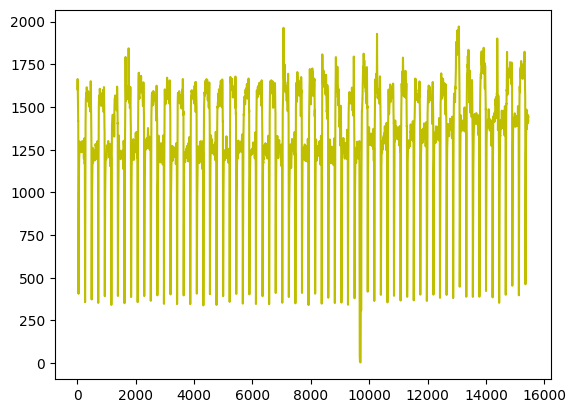

In [29]:
plt.plot(list(range(len(y_test))), y_test, color = "y")
plt.plot(list(range(len(y_test))), test_pre)